In [17]:
%pip install ipympl
%pip install matplotlib numpy sympy scipy h5py statsmodels
%matplotlib widget
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In this script we will showcase the steps taken in order to extract and listen to the signal produced by the collision of two black holes.
The steps performed are the following:
- Load the dataset and plot the values as a sanity check
- Use a subset of the dataset that doesn't contain the anomaly to estimate the _Power Density Spectrum_ of the noise present
- Window the subdataset to reduce the errors caused by the edge discontinuities
- Apply techniques to denoise the estimated _PDS_
- Construct a Whitening Filter from the denoised _PDS_
- Apply the Whitening Filter to the sample with the anomaly present and extract the desired uncorrelated signal
- Save the signal to a .wav file


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import h5py as hdf
import main
import importlib

# H1
h1 = main.SignalProcessor(name="H1-4096-4K") 

Its important to mention here that the signal gets normalized, so the mean is at zero. This is essential for computing the autocorrelation and autocovariance functions, so they only display the temporal dependencies in the signal without bias from a non-zero mean


1a) Periodogram

The anomaly starts at GPS Time 1126259462s, so we calculate the number of samples so that the resulting subdataset does not contain it. We make sure the number is not even so that the FIR filter design later results in a type I with no restrictions. Because the goal for the beginning is to analyse and later filter out the background noise.

At first we approached the amount of the needed Datapoints N like the following. The subdataset containing the N datapoints should be as big as possible to improve the frequency resolution of the periodogram and reduce the variance in the power spectral density (PSD) estimate. But according to the paper https://arxiv.org/pdf/1908.11170, a 1024s second sample is a good amount of data for a noise estimation.
We choose the data prior to the anomaly because there might be a slow system recovery or instrument artifacts, which can affect the noise characteristics.

Maximum n value:  4194303  out of  16777216


d:\dev\Second Version\PASA-P1\main.py:200: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


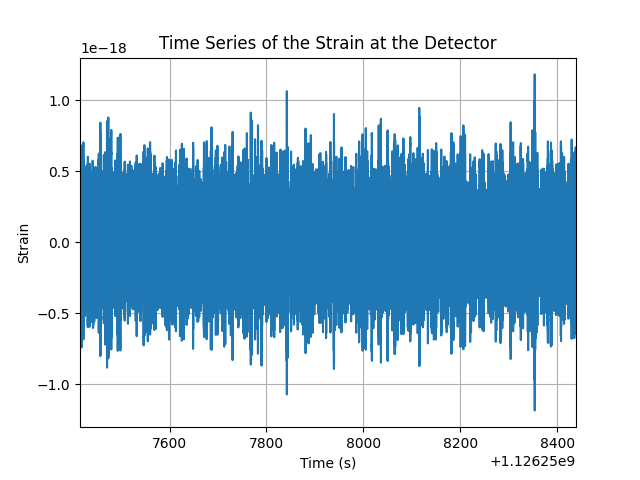

Amount of datapoints used: 4194303


In [19]:
anomaly_time = 1126259462
start_time = anomaly_time - 1024
xValues_h1, yValues_h1, N = h1.Subdataset(startTime=start_time, endTime=anomaly_time) # only look at 1024 seconds before the anomaly
main.plotSubdataset(xValues_h1, yValues_h1)
print(f"Amount of datapoints used: {N}")

In this stage we multiply the dataset by a window to reduce the spectral leakage. The chosen window was a Dolph Chebyshev window with 100 dB of equiripple attenuation. This window provides the narrowest mainlobe for a specified sidelobe level, compared to the other windows.

In [20]:
window = sp.windows.chebwin(h1.max_n, 100)
h1.yValues *= window

In this stage we first estimate the _PDS_ using a periodogram. This is calculated by taking the modulus squared of the FFT of the signal.

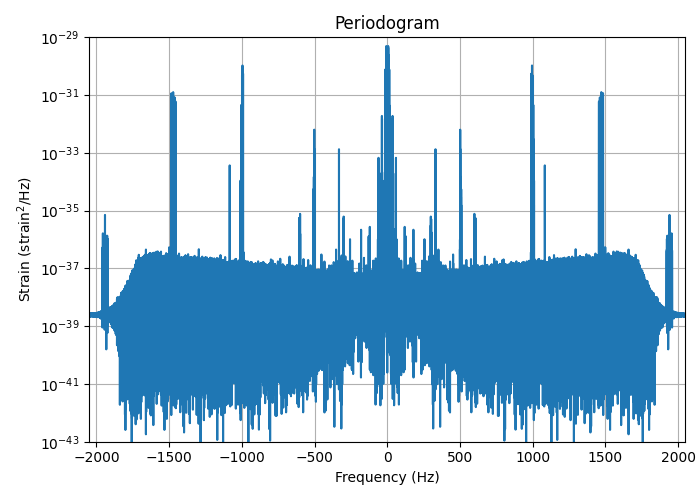

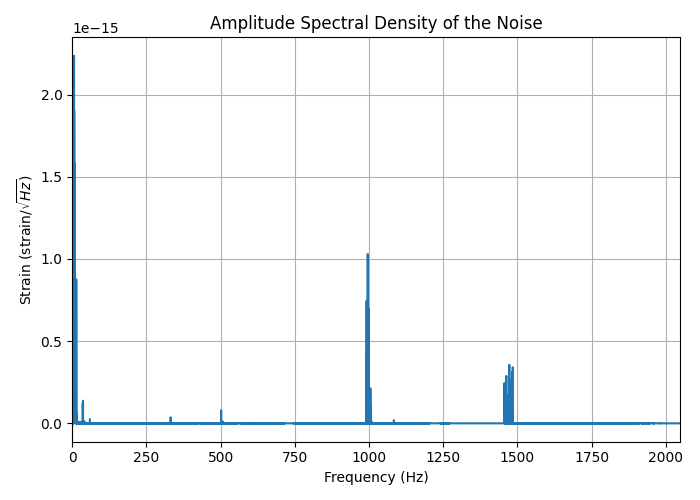

In [21]:
f_h1, R_y_h1 = h1.Periodogram()
main.periodogram_plotting(f_h1, R_y_h1, title="Periodogram")
main.ASD(f_h1, R_y_h1)


In the amplitude spectral density (ASD), disturbances within LIGO's detection band are clearly visible. These may originate from vibrations in the mirror suspension systems or from noise in the laser itself. The peak frequencies are similar in both graphs, indicating consistent noise sources.

For visualization purposes, only the positive frequency components of the ASD are shown.

1b) Periodogram smoothing

In this stage we apply a Periodogram Smoothing technique to reduce the variance of the Periodogram. In the following is the reasoning and explination of the parameters provided:

The L-factor represents the ratio of zero and nonzero samples in the rectangular Low Pass filter.

The factor $N=4194303$ datapoints was already discussed in the part 1a) and it`ll stay the same. 

The quantity $\Delta f \approx \left(\frac{1}{N} \right)(2M + 1)$ determines the frequency resolution (see Manolakis et all).
The human ear has a frequency resolution of approximately 3.6Hz.
If we aim for a $\Delta f$ of 3Hz with $Fs$ of 4KHz, then that is a normalized frequency of $0.00075$ and therefore $M$ can be calculated from the previous expression:
$(0.00075 * N - 1) / 2 = M = 1535 \approx 1500$

c:\Users\jtori\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\jtori\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


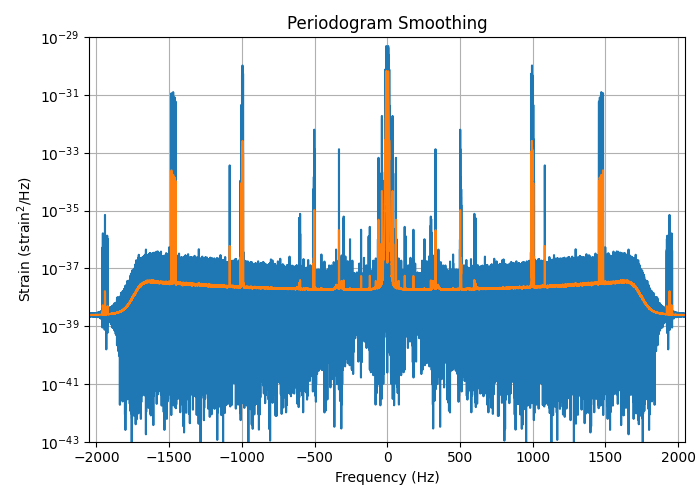

In [22]:
m = 1500
f_PS_h1, R_y_PS_h1 = h1.PeriodogramSmoothing(m=1500)
main.periodogram_plotting([f_h1, f_PS_h1], [R_y_h1, R_y_PS_h1], title="Periodogram Smoothing")

1c) Periodogram Averaging

The aim is to optimize periodogram averaging by adjusting the following parameters:

1. Segment Length (L):
This is the length of each data segment used for averaging.
Frequency resolution is inversely proportional to L.
A larger L gives better frequency resolution but fewer segments. In our case, we chose $L$ empirically after testing different values. It offered a reasonable balance between resolution and smoothness of the spectrum, while maintaining sufficient segment count.

2. Overlap Factor (D):
This controls how much the segments overlap.
Increasing overlap increases the number of segments (K).
A larger K reduces the variance of the power spectral density (PSD) estimate.
In Manolakis et all. there is the recommandation to use $D = 0.5$

3. Window: We choose Hanning. The window does not affect the variance. But it helps to suppres the side lobes

In the following graph you can see, that there is a scaling issue, which is probably caused by the segmenting. But for the following analysis it should not bother because we are focusing on identifying the dominant noise frequencys to filter out.

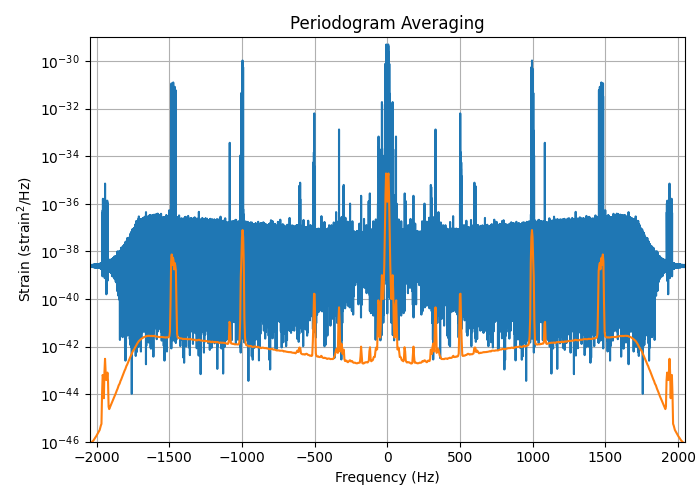

Number of segments K: 8387


In [23]:
f_PA_h1, R_y_PA_h1, K_h1 = h1.PeriodogramAveraging(L=1000, D=0.5, window='Hanning')
main.periodogram_plotting([f_h1, f_PA_h1], [R_y_h1, R_y_PA_h1], ylim=(1e-46, 1e-29), title="Periodogram Averaging")    
print(f"Number of segments K: {K_h1}")

1d) The best method

The Literature recommends the averaged periodogram. Because it has in general lower variance and the spectral estimate is statistically more stable. 

The original periodogram has a very high variance and the variance doesnt decrease with the increase of datapoints. That means it is unreliable for a consistent spectral analysis. 

Periodogram averaging reduces the variance of the Periodogram better than the smoothing, because the each segment provides an independent estimate. The averaging over many segments leads to more stable and less noisy result. You can see this in the following plot. The periodogram averaging is more smooth than the periodogram smoothing. 

Furthermore averaging periodogram doesnt have the Bias-Variance Trade as smoothing. Smoothing trades frequency resolution for lower variance, but it can introduce bias near peaks. You can notice this in the following plot at the peak at the $f=1000 Hz$.  

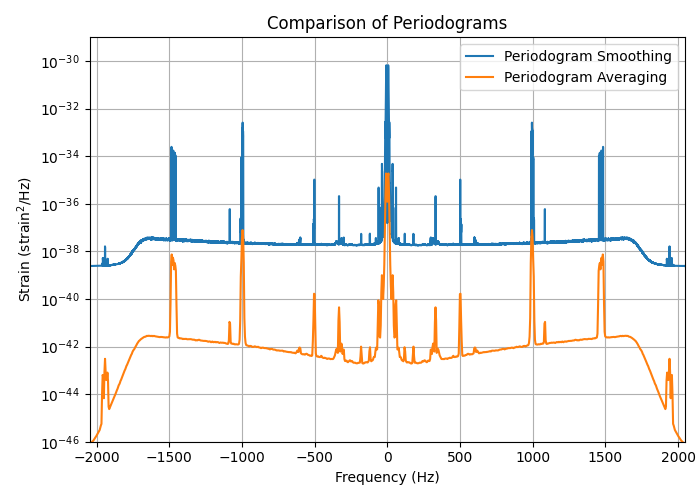

In [24]:
# main.periodogram_plotting([f_h1, f_PS_h1, f_PA_h1], [R_y_h1, R_y_PS_h1, R_y_PA_h1], title="Comparison of Periodograms", ylim=(1e-43, 1e-29), labels=["Periodogram", "Periodogram Smoothing", "Periodogram Averaging"])
main.periodogram_plotting([f_PS_h1, f_PA_h1], [R_y_PS_h1, R_y_PA_h1], title="Comparison of Periodograms", ylim=(1e-46, 1e-29), labels=["Periodogram Smoothing", "Periodogram Averaging"])

1e) Comparison of H1 and L1

Maximum n value:  4194303  out of  16777216


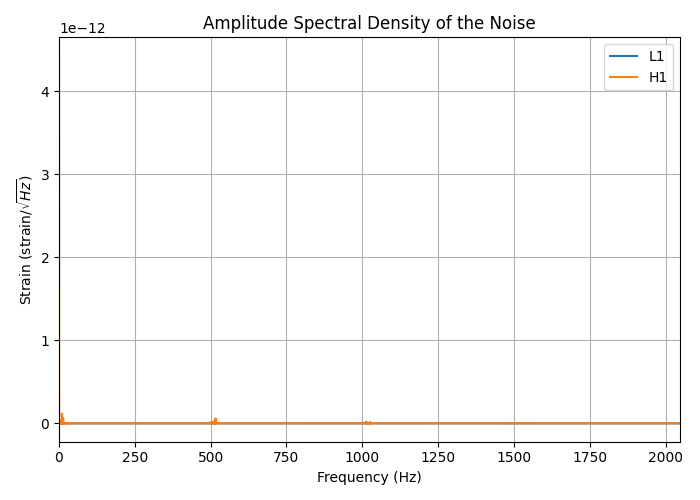

c:\Users\jtori\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


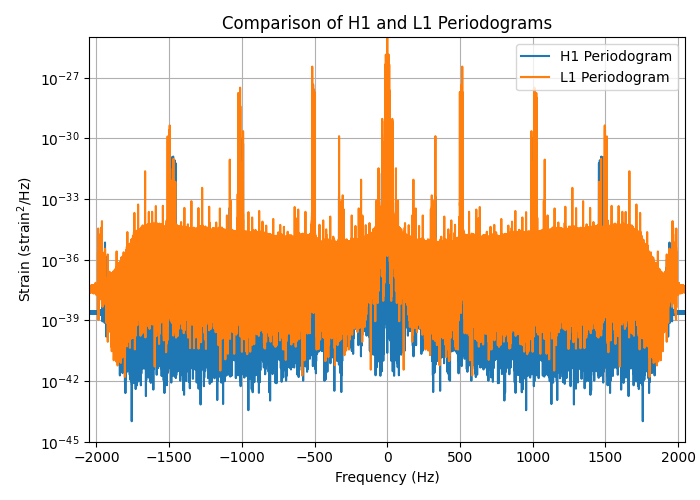

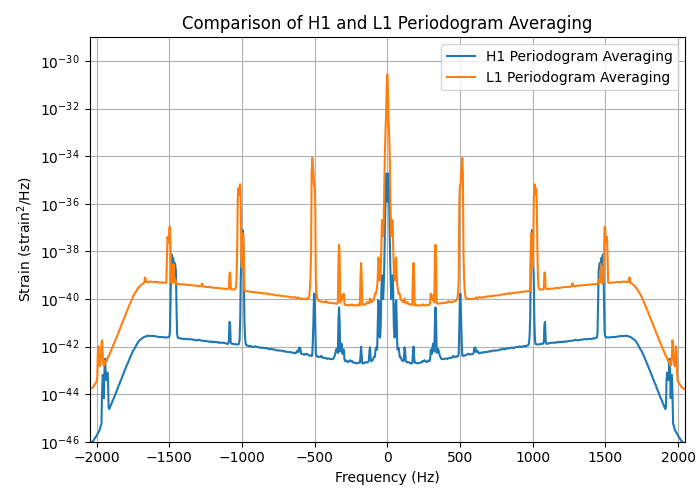

In [25]:
L1 = main.SignalProcessor(name="L1-4096-4K")
L1.Subdataset(startTime=start_time, endTime=anomaly_time, plot =False)
# L1.WindowSubdataset()
f_L1, R_y_L1 = L1.Periodogram()
# main.periodogram_plotting(f_L1, R_y_L1, title="Periodogram L1")
main.ASD([f_h1, f_L1], [R_y_h1, R_y_L1], labels=["L1", "H1"])
main.periodogram_plotting([f_h1, f_L1], [R_y_h1, R_y_L1], title="Comparison of H1 and L1 Periodograms", ylim=(1e-45, 1e-25), labels=["H1 Periodogram", "L1 Periodogram"])    
f_PA_L1, R_y_PA_L1, K_L1 = L1.PeriodogramAveraging(L=1000, D=0.5, window = 'Hanning')
main.periodogram_plotting([f_PA_h1, f_PA_L1], [R_y_PA_h1, R_y_PA_L1], title="Comparison of H1 and L1 Periodogram Averaging", ylim=(1e-46, 1e-29), labels=["H1 Periodogram Averaging", "L1 Periodogram Averaging"])


Amplitude spectral density analysis:
When comparing our results to the LIGO noise and sensitivity plot provided in the task sheet, we can attribute the low-frequency disturbances to suspension thermal noise, as expected. Additionally, the spectral peaks observed around 1000 Hz and 1400 Hz correspond to noise sources that can affect LIGO's sensitivity. We can also see that the noise in L1 has more energy because it has a higher amplitude than the noise in H1. Furthermore the amplitude peaks between L1 and H1 are also shifted (f.e. at $f=1000Hz$). 

Power spectal density analysis:
The nose of H1 has in general a lower noise level. That fits to our observation in the ASD. 
Peak comparison: Furthermore for low frequencys are the peaks in L1 higher than in H1. It goes even so far, that L1 has a peak at 175 Hz and H1 not.On the other side the peaks for frequencys above ca. $f=1250Hz$ are higher in H1.
Bias: If we compare the averaged periodograms to the original periodograms. Lets say at the peak at the frequency ca. $500Hz$.
(H1: originally 501.8; averaged 505.125 -
L1: originally 515.9; averaged 514.925) 
These are all values estimated by eye, but we think it is clear that L1 leads to less bais.
Variance: After ajusting the parameters of the averaging, the variance is almost equal.


1f) Validation of the stationarity

A signal is stationary if its statistical properties (mean, variance, autocorrelation, ...) stay the same over time. That means the stationary signal is in the frequency domain always the same, it doesnt matter at which timewindow we look at it.
After some research we found different methods to test for stationarity. For example the augmented Dickey-Fuller or Kwiatkowski-Phillips-Schmidt-Shin test. 
We test the stationarity of the signals with the help of the augmented Dickey-Fuller test, by literature it is the most commen one.

In [26]:
# Implementation of augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller, kpss
w_comp = 20000
offset = 100
signals = [h1, L1]
for signal in signals:
    yValues = (signal.yValues - np.mean(signal.yValues)) / np.std(signal.yValues) # normalizse the signals
    print(f"Signal: {signal.name}")
    result = adfuller(yValues[offset:offset + w_comp])
    print('p-value: %f' % result[1])
    if result[1] < 0.05:
        print("The signal is stationary")
    else:
        print("The signal is non-stationary")


Signal: H1-4096-4K
p-value: 0.000000
The signal is stationary
Signal: L1-4096-4K
p-value: 0.000000
The signal is stationary


2) Whitening Filter

In this stage we calculate the Whitening Filter derived from the denoised _PDS_. In order to achieve this we created a FIR filter of N taps where each frequency sample takes the value of 1/(sqrt(PDS(f))). This way the filter not only flattens the noise spectrum.

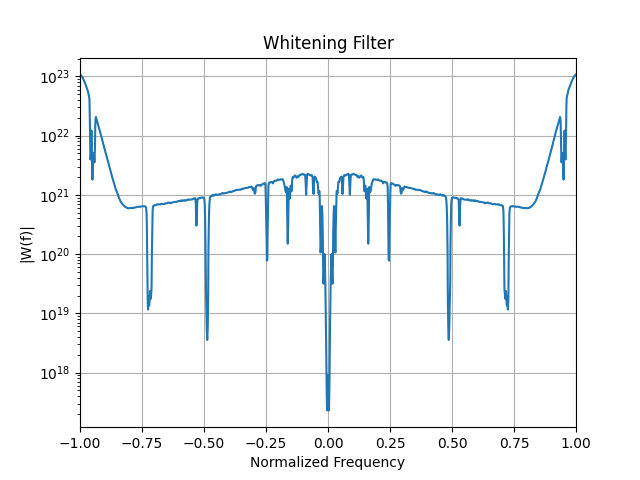

In [27]:
h1_W_f = h1.WhiteningFilter(mode="Averaging") 

The last step in the processing is to apply the Whitening Filter to the subdataset with the anomaly. To do this, a subdataset of size N centered in the anomaly time is taken from the original dataset.

(2096000.0, 2098000.0)

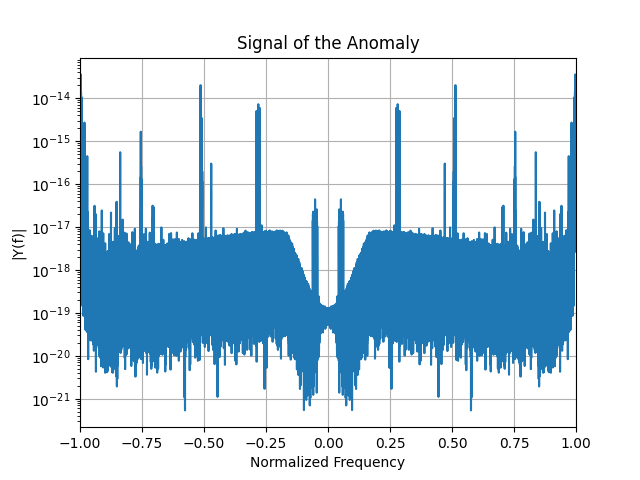

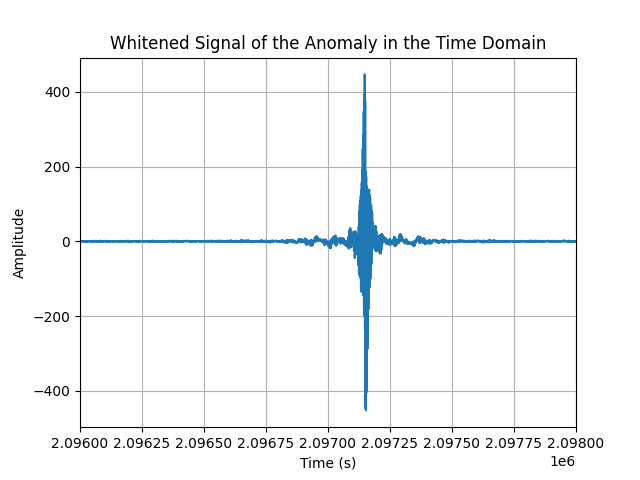

In [28]:
h1_result = h1.Whiten(N, 0.2)
plt.figure()
plt.plot(h1_result)
plt.title("Whitened Signal of the Anomaly in the Time Domain")
plt.ylabel("Amplitude")
plt.xlabel("Time (s)")
plt.grid(True)
plt.xlim(2.096e6, 2.098e6)

Last but not least, a cropped segment of the restored signal is saved to a file

In [29]:
h1.SaveToFile(6, 0.5)

3) Estimation of the cone angle

In this last part of the script we will calculate the time delay of the two events to calculate the cone from where the signal could have came from

Maximum n value:  4194303  out of  16777216


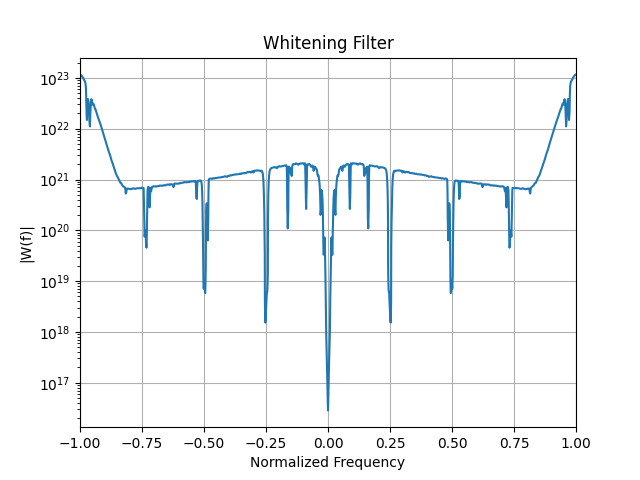

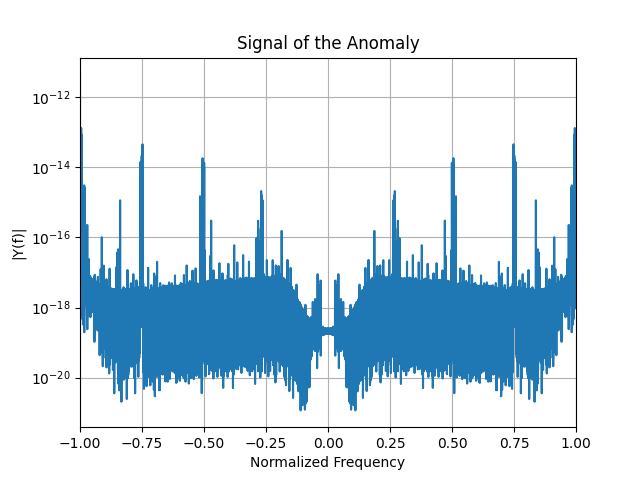

In [30]:
L1 = main.SignalProcessor(name="L1-4096-4K")
xValues_h1, yValues_h1, N_L1 = L1.Subdataset(startTime=start_time, endTime=anomaly_time)
L1.WindowSubdataset()
L1.Periodogram()
L1.PeriodogramSmoothing(m=m)
L1.PeriodogramAveraging(L=1000, D=0.5, window='Hanning')
l1_W_f = L1.WhiteningFilter(mode="Averaging")
l1_result = L1.Whiten(N_L1, 0.2)
L1.SaveToFile(6, 0.5)

In [31]:
import copy

# Print overlapped H1 & L1
t_l1 = np.linspace(L1.XStart, L1.XStart + L1.N * L1.dX, L1.N)
t_h1 = np.linspace(h1.XStart, h1.XStart + h1.N * h1.dX, h1.N)

L1_dset = copy.copy(L1.values)
H1_dset = copy.copy(h1.values)

w_f = np.fft.ifft(l1_W_f).real
w_f_scaled = np.zeros(L1_dset.shape[0])
start = (L1_dset.shape[0] - w_f.shape[0] ) // 2
w_f_scaled[start:start + w_f.shape[0]] = w_f
W_f_scaled = np.fft.fft(w_f_scaled)
L1_dset_f = np.fft.fft(L1_dset)
l1_filt = np.fft.ifft( L1_dset_f * W_f_scaled ).real
l1_filt /= max(l1_filt)


w_f = np.fft.ifft(h1_W_f).real
w_f_scaled = np.zeros(H1_dset.shape[0])
start = (H1_dset.shape[0] - w_f.shape[0] ) // 2
w_f_scaled[start:start + w_f.shape[0]] = w_f
W_f_scaled = np.fft.fft(w_f_scaled)
H1_dset_f = np.fft.fft(H1_dset)
h1_filt = np.fft.ifft( H1_dset_f * W_f_scaled ).real
h1_filt /= max(h1_filt)

plt.figure()
plt.plot(t_l1, l1_filt, label="L1")
plt.plot(t_h1, h1_filt, label="H1")
plt.xlabel("Time [s]")
plt.ylabel("Normalized Amplitude")
plt.title("Comparisson of Whitened Signals")
plt.legend()

correlation = sp.correlate(l1_filt, h1_filt, mode="same")
correlation_lags = sp.correlation_lags(l1_filt.shape[0], h1_filt.shape[0], mode="same")
max_corr_idx = correlation.tolist().index(max(correlation))
lag = correlation_lags[max_corr_idx]

print(lag)

KeyboardInterrupt: 

The lag result obtained using the Periodogram Averaging method was inconsistent with the expected results of aproximately 10ms delay between the signals of both detectors. The obtained value using Averaging was a lag of 5 samples, which with a sampling frequency of 4KHz is 1.25 ms. However, using the Periodogram Smoothing technique, the obtained lag value was of 24 samples which translates to 6.25 ms. This result is a lot more reasonable. Unfortunately we cannot explain the difference/error between these two measurements. In order to see the Smoothing results, the mode parameter can be changed in the WhiteningFilter method call. The cone angle or arrival can be derived from the difference in optical path calculated like Delta Time * C.